## Import the Libraries

In [1]:
import torch
from torch import nn 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import timeit
from tqdm import tqdm
import os

## Defining the Hyperparmeters

- *Setting the seed means initializing a random number generator (RNG) with a fixed starting point. This ensures that the sequence of random numbers generated remains the same every time you run the program.*



In [2]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10 #As we will train on MNIST Dataset
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768 #This is for the MLP Head 
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9,0.999) #Used in Paper
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2 ) * IN_CHANNELS
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2  

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


## Patch Embedding Class

- *CLS_Token is the first token in the Patch_Embedding Sequence which contains all the details of the Class as well as other tokens and It is a Learnable Parameter.*

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(torch.randn(size = (1,in_channels, embed_dim)), requires_grad=True)
        self.positional_embedding = nn.Parameter(torch.randn(size = (1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p = dropout)
    
    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) #-1 implies that the original dimension will remain unchanged
        
        x = self.patcher(x).permute(0,2,1)
        
        #This will join the cls_token with each respected elements of x
        x = torch.cat([cls_token, x], dim=1)
        
        #Now join the Patch Embedding and Positional Encodings together
        x = self.positional_embedding + x
        x = self.dropout(x)
        
        return x 
        
model = PatchEmbedding(EMBED_DIM,PATCH_SIZE,NUM_PATCHES,DROPOUT,IN_CHANNELS).to(DEVICE)
x = torch.randn(512,1,28,28)
print(model(x).shape)        
        
        

torch.Size([512, 50, 16])


## Vision Transformer Architecture

In [4]:
class Vit(nn.Module):
    def __init__(self, num_patches,img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embedding_block = PatchEmbedding(embed_dim,patch_size, num_patches,dropout,in_channels)
        
        #This will generate only one Encoder Layer of our Transformer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        
        #This will generate the multiple encoder layers which are required by our Vision Transformer
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer,num_layers=num_encoders)
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes) #For classification Purpose
        )
        
    def forward(self, x):
        x = self.embedding_block(x)  #Passing Input through PatchEmbedding
        x = self.encoder_blocks(x)   #Passing Input through Encoder Layers
        x = self.mlp_head(x[:,0,:])  #Passing Input through MLP_Head but we will only take the CLS_Tokens
        
        return x 
    

model = Vit(NUM_PATCHES,IMG_SIZE,NUM_CLASSES,PATCH_SIZE,EMBED_DIM,NUM_ENCODERS,NUM_HEADS,HIDDEN_DIM,DROPOUT,ACTIVATION,IN_CHANNELS).to(DEVICE)
x = torch.randn(512,1,28,28).to(DEVICE)  #Define a random Image
print(model(x).shape)

c:\Python\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([512, 10])


## Dataset Preparation

In [5]:
train_df = pd.read_csv("D:/Atharva/Implementations/Vision_Transformer/data/train.csv")
test_df = pd.read_csv("D:/Atharva/Implementations/Vision_Transformer/data/test.csv")


### Dataset Visualization

In [6]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train_df , val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)



### Train Data Class

In [9]:
class MNISTrainData(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    #Simple Length function which will return the length of the Train Dataset
    def __len__(self):
        return len(self.images)
    
    #A function which will return the data at the specific index when an index is passed to it.
    def __getitem__(self,idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transform(image)
        
        return {"image":image, "label":label, "index":index}
    
    

### Validation Data Class

- We will not perform Data Augmentation for Valid Dataset

In [10]:


class MNISValidData(Dataset):
    def __init__(self, images,labels,indices):
        super().__init__()
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
    
    #Simple Length function which will return the length of the Train Dataset
    def __len__(self):
        return len(self.images)
    
    #A function which will return the data at the specific index when an index is passed to it.
    def __getitem__(self,idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transform(image)
        
        return {"image":image, "label":label, "index":index}       

### Test Data Class

- We will not give Labels to Test Dataset

In [11]:
class MNISTestData(Dataset):
    def __init__(self, images, indices):
        super().__init__()
        self.images = images
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)
        index = self.indices[idx]
        image = self.transform(image)
        
        return {"image":image, "index":index}
        

    

- Code to visualize an image from the dataset

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

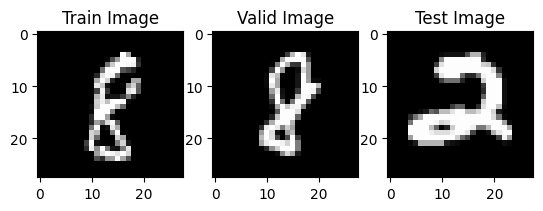

In [12]:
plt.figure()
f, axarr = plt.subplots(1,3) #3 as we have Train,Test,Valid Datasets

#train_df.iloc[:, 1:] we are doing this because in the first column is Labels which do not want for images, We want labels to be separate 
train_dataset = MNISTrainData(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:,0].values, train_df.index.values)

#Check to see if dataset is successfully loaded or not 
print(len(train_dataset))
print(train_dataset[0])

axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("+"*30)

val_dataset = MNISValidData(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:,0].values, val_df.index.values)

#Check to see if dataset is successfully loaded or not 
print(len(val_dataset))
print(val_dataset[0])

axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Valid Image")
print("+"*30)


test_dataset = MNISTestData(test_df.values.astype(np.uint8),test_df.index.values)

#Check to see if dataset is successfully loaded or not 
print(len(test_dataset))
print(test_dataset[0])

axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("+"*30)



In [13]:
train_data_loader = DataLoader(train_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

val_data_loader = DataLoader(val_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

test_data_loader = DataLoader(test_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

- The weight_decay parameter in Adam is used for L2 regularization, which prevents overfitting by penalizing large weights.

## If weights available do this

In [14]:
checkpoint_path = "D:\Atharva\Implementations\Vision_Transformer\checkpoints\weights_epoch_40.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\athar\AppData\Local\Temp\ipykernel_18264\3432225848.py:1: SyntaxWarning: invalid escape sequence '\A'
  checkpoint_path = "D:\Atharva\Implementations\Vision_Transformer\checkpoints\weights_epoch_40.pth"
C:\Users\athar\AppData\Local\Temp\ipykernel_18264\3432225848.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

<All keys matched successfully>

In [15]:
model.eval()


Vit(
  (embedding_block): PatchEmbedding(
    (patcher): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(4, 4))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
    (dropout): Dropout(p=0.001, inplace=False)
  )
  (encoder_blocks): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=2048, bias=True)
        (dropout): Dropout(p=0.001, inplace=False)
        (linear2): Linear(in_features=2048, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.001, inplace=False)
        (dropout2): Dropout(p=0.001, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((16,), eps=

### Function to calculate the accuracy of the functiion

In [21]:
def calculate_accuracy(model, data_loader):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for img_label in tqdm(data_loader, desc="Evaluating", leave=False):
            img = img_label["image"].float().to(DEVICE)
            label = img_label["label"].type(torch.uint8).to(DEVICE)
            
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            correct += (y_pred_label == label).sum().item()
            total += label.size(0)
            
    accuracy = correct / total*100
    return accuracy

In [23]:
train_accuracy = calculate_accuracy(model, train_data_loader)
val_accuracy = calculate_accuracy(model, val_data_loader)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy:{val_accuracy:.2f}%")

Train Accuracy: 93.44%
Validation Accuracy:94.43%


## If weights not available do this

### Training Loop

In [19]:
#Add a Loss Function
criterion = nn.CrossEntropyLoss()
#Add a Optimizer 
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

os.makedirs("checkpoints", exist_ok=True)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = []
    for idx, img_label in enumerate(tqdm(train_data_loader, position=0, leave=True)):
        img = img_label["image"].float().to(DEVICE)
        label = img_label["label"].type(torch.uint8).to(DEVICE)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)
        
        #Free GPU Memory by transferring the labels, predictions to CPU 
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_running_loss.append(loss.item())
        
    #Train Loss stores value of Loss after each epoch    
    train_loss = sum(train_running_loss) / len(train_running_loss)
    
    torch.save(model.state_dict(), f'checkpoints/weights_epoch_{epoch + 1}.pth')
    print(f"Epoch: {epoch + 1}: Model Weights  saved at:- 'checkpoints/weights_epoch_{epoch + 1}.pth'")
    
        
        

  2%|▎         | 1/40 [05:29<3:34:02, 329.30s/it]

Epoch: 1: Model Weights  saved at:- 'checkpoints/weights_epoch_1.pth'


  5%|▌         | 2/40 [10:53<3:26:39, 326.29s/it]

Epoch: 2: Model Weights  saved at:- 'checkpoints/weights_epoch_2.pth'


  8%|▊         | 3/40 [16:22<3:21:50, 327.31s/it]

Epoch: 3: Model Weights  saved at:- 'checkpoints/weights_epoch_3.pth'


 10%|█         | 4/40 [22:02<3:19:24, 332.35s/it]

Epoch: 4: Model Weights  saved at:- 'checkpoints/weights_epoch_4.pth'


 12%|█▎        | 5/40 [28:12<3:21:52, 346.08s/it]

Epoch: 5: Model Weights  saved at:- 'checkpoints/weights_epoch_5.pth'


 15%|█▌        | 6/40 [34:32<3:22:42, 357.72s/it]

Epoch: 6: Model Weights  saved at:- 'checkpoints/weights_epoch_6.pth'


 18%|█▊        | 7/40 [40:19<3:14:47, 354.15s/it]

Epoch: 7: Model Weights  saved at:- 'checkpoints/weights_epoch_7.pth'


 20%|██        | 8/40 [45:58<3:06:15, 349.23s/it]

Epoch: 8: Model Weights  saved at:- 'checkpoints/weights_epoch_8.pth'


 22%|██▎       | 9/40 [51:48<3:00:34, 349.51s/it]

Epoch: 9: Model Weights  saved at:- 'checkpoints/weights_epoch_9.pth'


 25%|██▌       | 10/40 [57:30<2:53:36, 347.23s/it]

Epoch: 10: Model Weights  saved at:- 'checkpoints/weights_epoch_10.pth'


 28%|██▊       | 11/40 [1:03:14<2:47:24, 346.35s/it]

Epoch: 11: Model Weights  saved at:- 'checkpoints/weights_epoch_11.pth'


 30%|███       | 12/40 [1:08:43<2:39:04, 340.87s/it]

Epoch: 12: Model Weights  saved at:- 'checkpoints/weights_epoch_12.pth'


 32%|███▎      | 13/40 [1:13:56<2:29:41, 332.65s/it]

Epoch: 13: Model Weights  saved at:- 'checkpoints/weights_epoch_13.pth'


 35%|███▌      | 14/40 [1:19:17<2:22:31, 328.91s/it]

Epoch: 14: Model Weights  saved at:- 'checkpoints/weights_epoch_14.pth'


 38%|███▊      | 15/40 [1:24:35<2:15:45, 325.82s/it]

Epoch: 15: Model Weights  saved at:- 'checkpoints/weights_epoch_15.pth'


 40%|████      | 16/40 [1:29:51<2:09:05, 322.71s/it]

Epoch: 16: Model Weights  saved at:- 'checkpoints/weights_epoch_16.pth'


 42%|████▎     | 17/40 [1:35:10<2:03:15, 321.55s/it]

Epoch: 17: Model Weights  saved at:- 'checkpoints/weights_epoch_17.pth'


 45%|████▌     | 18/40 [1:40:33<1:58:06, 322.11s/it]

Epoch: 18: Model Weights  saved at:- 'checkpoints/weights_epoch_18.pth'


 48%|████▊     | 19/40 [1:45:53<1:52:31, 321.48s/it]

Epoch: 19: Model Weights  saved at:- 'checkpoints/weights_epoch_19.pth'


 50%|█████     | 20/40 [1:51:13<1:46:59, 320.98s/it]

Epoch: 20: Model Weights  saved at:- 'checkpoints/weights_epoch_20.pth'


 52%|█████▎    | 21/40 [1:56:30<1:41:14, 319.73s/it]

Epoch: 21: Model Weights  saved at:- 'checkpoints/weights_epoch_21.pth'


 55%|█████▌    | 22/40 [2:01:47<1:35:39, 318.84s/it]

Epoch: 22: Model Weights  saved at:- 'checkpoints/weights_epoch_22.pth'


 57%|█████▊    | 23/40 [2:07:05<1:30:17, 318.68s/it]

Epoch: 23: Model Weights  saved at:- 'checkpoints/weights_epoch_23.pth'


 60%|██████    | 24/40 [2:12:22<1:24:51, 318.20s/it]

Epoch: 24: Model Weights  saved at:- 'checkpoints/weights_epoch_24.pth'


 62%|██████▎   | 25/40 [2:17:41<1:19:35, 318.35s/it]

Epoch: 25: Model Weights  saved at:- 'checkpoints/weights_epoch_25.pth'


 65%|██████▌   | 26/40 [2:22:59<1:14:15, 318.28s/it]

Epoch: 26: Model Weights  saved at:- 'checkpoints/weights_epoch_26.pth'


 68%|██████▊   | 27/40 [2:28:14<1:08:46, 317.44s/it]

Epoch: 27: Model Weights  saved at:- 'checkpoints/weights_epoch_27.pth'


 70%|███████   | 28/40 [2:33:30<1:03:22, 316.88s/it]

Epoch: 28: Model Weights  saved at:- 'checkpoints/weights_epoch_28.pth'


 72%|███████▎  | 29/40 [2:38:47<58:07, 317.08s/it]  

Epoch: 29: Model Weights  saved at:- 'checkpoints/weights_epoch_29.pth'


 75%|███████▌  | 30/40 [2:44:06<52:53, 317.40s/it]

Epoch: 30: Model Weights  saved at:- 'checkpoints/weights_epoch_30.pth'


 78%|███████▊  | 31/40 [2:49:25<47:42, 318.04s/it]

Epoch: 31: Model Weights  saved at:- 'checkpoints/weights_epoch_31.pth'


 80%|████████  | 32/40 [2:54:45<42:29, 318.64s/it]

Epoch: 32: Model Weights  saved at:- 'checkpoints/weights_epoch_32.pth'


 82%|████████▎ | 33/40 [3:00:01<37:04, 317.79s/it]

Epoch: 33: Model Weights  saved at:- 'checkpoints/weights_epoch_33.pth'


 85%|████████▌ | 34/40 [3:05:18<31:45, 317.58s/it]

Epoch: 34: Model Weights  saved at:- 'checkpoints/weights_epoch_34.pth'


 88%|████████▊ | 35/40 [3:10:35<26:27, 317.50s/it]

Epoch: 35: Model Weights  saved at:- 'checkpoints/weights_epoch_35.pth'


 90%|█████████ | 36/40 [3:15:51<21:07, 316.92s/it]

Epoch: 36: Model Weights  saved at:- 'checkpoints/weights_epoch_36.pth'


 92%|█████████▎| 37/40 [3:21:16<15:58, 319.43s/it]

Epoch: 37: Model Weights  saved at:- 'checkpoints/weights_epoch_37.pth'


 95%|█████████▌| 38/40 [3:26:33<10:37, 318.72s/it]

Epoch: 38: Model Weights  saved at:- 'checkpoints/weights_epoch_38.pth'


 98%|█████████▊| 39/40 [3:31:49<05:17, 317.91s/it]

Epoch: 39: Model Weights  saved at:- 'checkpoints/weights_epoch_39.pth'


100%|██████████| 40/40 [3:37:08<00:00, 325.72s/it]

Epoch: 40: Model Weights  saved at:- 'checkpoints/weights_epoch_40.pth'


## Test Loop

In [27]:
labels = []
ids = []
imgs = []
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_data_loader, desc="Testing", position=0, leave=True)):
        img = sample["image"].to(DEVICE)
        
        outputs = model(img)
        
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)]) 



        
    

Testing:   0%|          | 0/55 [00:00<?, ?it/s]

Testing: 100%|██████████| 55/55 [00:40<00:00,  1.37it/s]


In [ ]:
#Now we plot the results 
plt.figure()
f, axarr = plt.subplots(2,4)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap='gray')
        axarr[i][j].set_title(f"Predicted Label:- {labels[counter]}")
        counter +=1 
f.suptitle("Digit Recognition Results", fontsize = 13)        
plt.show()